In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
start_time = time.time()

# Used for loading csv files into excel
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import os
import glob

In [2]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [3]:
def sorted_dict(file_names):
    '''
    Input: Requires a list of .csv files
    Output:
    - A dictionary with values sorted according to the train trip
    - file_names excluding '.csv'
    
    '''

    d = {}

    # Retrieve file_names
    file_names = ''.join(all_files).split('.csv')[:-1]


    for name in file_names:

    # If name of file as a digit, find index of digit
        if hasNumbers(name):

    # Find the index of the digit
            idx = [char.isdigit() for char in name].index(True)

    # Split by the index and store the front end as the key
    # Note: '-1' is to exclude the whitespace as well
            key = name[:idx-1]
            if key in d:
                d[key].append(name)
            else:
                d[key] = [name]
        else:
            if name in d:
                d[name].append(name)
            else:
                d[name] = [name]

    
    return d, file_names


In [4]:
def csv_to_excel(d, wb, acc_header):
    '''
    Input: A dictionary of .csv file names, Excel workbook, Header of acceleration values to calculate average acceleration values
    Output: Data imported into excel workbook
    '''


    # For each key in dictionary
    for i, key in enumerate(d):

    #     Convert the respective files into a list of df
        df_list = [pd.read_csv(f'{file}.csv') for file in d[key]]

    #     Concatenate the dfs into 1
        concat_df = pd.concat(df_list, axis = 1)

    #     Create a new column: Average of all acceleration data
        try:
            concat_df['Average Y'] = concat_df[acc_header].mean(axis=1)
        except:
    #         If only have 1 set of readings, still need to create a new column
            concat_df['Average Y'] = concat_df[acc_header].mean()
      
    #     Store key as title of file
        title = key

    #     Create ws with the title == key of dictionary
        ws = wb.create_sheet(index=i, title=title)

    #     Import the df into the excel sheet
        for r in dataframe_to_rows(concat_df, index=False, header=True):
            ws.append(r)

    try:
        wb.save(f'{excel_wb_name}.xlsx')
        print(f"Excel workbook created at {user_dir}")
    except:
        print('''
        Excel file failed to create. 
        Please check that the name given does not contain the following special characters:
        / \ : * ? " < > | ''')

In [5]:
# Create new Excel workbook
wb = openpyxl.Workbook()
# Just to remove the spare sheet
wb.remove(wb.active)

# Retrieve directory containing all .csv files
user_dir = input("Please input the path to the directory containing all the .csv files: ")
path = 'c:\\'
extension = 'csv'
os.chdir(user_dir)
all_files = glob.glob('*.{}'.format(extension))
d, file_names = sorted_dict(all_files)

# Ask User for header of timestamp, of acc values
t_header = input("Please input the name of the header for the timestamp column (CASE-SENSITIVE): ")
acc_header = input("Please input the name of the header for the acceleration column (CASE-SENSITIVE): ")
excel_wb_name = input("An excel workbook will be created. Please input your preferred name (CASE-SENSITIVE): ")
print("File is running...")

try:
    csv_to_excel(d, wb, acc_header)
except Exception as e:
    print(e)
    print("Please ensure that the folder only contains .csv files for the accelerometer readings.")


Please input the path to the directory containing all the .csv files: ../data
Please input the name of the header for the timestamp column (CASE-SENSITIVE): loggingTime
Please input the name of the header for the acceleration column (CASE-SENSITIVE): accelerometerAccelerationZ
An excel workbook will be created. Please input your preferred name (CASE-SENSITIVE): outputZ
File is running...
Excel workbook created at ../data


In [6]:
print(f'''
Reading Excel file...''')
acceleration_data = pd.read_excel(f'{excel_wb_name}.xlsx', sheet_name=None, header=None)



Reading Excel file...


In [7]:
def format_headers(df):
    
# Format headers as long as the first row is not a numerical value
# Note: Headers are not considered as the first row
# Note: '.item()' is to convert numpy types to native Python types
    try:
        if type(df.iloc[0, 0].item()) == float:
            pass
    except:
        header = df.iloc[0]
        df = df[1:]
        df.columns = header
    return df

In [8]:
def get_total_speed(velocity):
    '''
    Takes in the calculated velocity.
    Returns a list of speed at each timestamp
    '''

def get_max_v(acc, method = 's'):
    '''
    Returns a float by integrating acceleration via Simpson's Rule
    '''
    acc = list(acc)
    cleaned_acc = [el for el in acc if str(el) != 'nan']
    
    d_v = []
    accum_v = []
    max_v = 0
    
    if method.lower() == 's':
        for i in range(0, len(cleaned_acc)-2, 2):
        #     Simpson's Rule
            velocity = ((0.02)/3) * (cleaned_acc[i] + 4 * cleaned_acc[i+1] + cleaned_acc[i+2])
            d_v.append(velocity)
            
#         To obtain accumulated velocity (NOT SPEED) at each timestamp NOTE: REPEATED CODE
# Should be velocity so that if change in velocity is negative, then the velocity will decrease accordingly
# I guess technically, can be speed also coz if change in velocity is negative, it means object is slowing down
            if i == 0:
                accum_v.append(velocity)
            else:
                accum_v.append(velocity + accum_v[-1]) 

#             accum_v.append(sum(d_v))
            
#         Just to speed up the loop so that I don't always have to sum up the array and check with max_v
            if i < len(cleaned_acc)*0.2:
                continue

            if sum(d_v) > max_v:
                max_v = sum(d_v)
                
    else:
        for i in range(0, len(cleaned_acc)-1):
            velocity = (1/2) * (cleaned_acc[i+1]+cleaned_acc[i]) * 0.02
            d_v.append(velocity)
            
#         To obtain accumulated velocity (NOT SPEED) at each timestamp NOTE: REPEATED CODE
            if i == 0:
                accum_v.append(velocity)
            else:
                accum_v.append(velocity + accum_v[-1]) 
            
#         Just to speed up the loop so that I don't always have to sum up the array and check with max_v
            if i < len(cleaned_acc)*0.2:
                continue

            if sum(d_v) > max_v:
                max_v = sum(d_v)
            
            
    return max_v, accum_v


In [9]:
# ARCHIVED
# def get_total_dist(accum_v, method = 's'):
#     total_dist = 0
#     for i in accum_v:
            
# #         In Sinusoidal method, the time-interval is over 2 data points for it is for a parabola
#             if method.lower() == 's': 
#                 total_dist += 0.04 * abs(i)
# #       In Trapezoidal method, the time-interval is over 1 data point
#             else:
#                 total_dist += 0.02 * abs(i)
            
#     return total_dist

def get_total_dist(accum_v, method = 's'):
    
#     To make sure that even if velocity is negative, we still add 
# Note: Should NOT be possible for velocity to be negative for the train does NOT move backwards!
    speed_arr = np.abs(np.array(accum_v))
    
#     In Sinusoidal method, the time-interval is over 2 data points for it is for a parabola
    if method == 's':
        total_dist = sum(np.multiply(speed_arr, 0.04))
        
#     In Trapezoidal method, the time-interval is over 1 data point
    else:
        total_dist = sum(np.multiply(speed_arr, 0.02))
        
    return total_dist

In [10]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [11]:
def retrieve_x_and_y_axes(df):
    '''
    Returns the x and y axes for the plotting of graph
    x-axis: Time
    y-axis: Average Acceleration
    '''
    
    try: 
    # Remove all rows where all values are blank then Retrieve the last value    
        last_value_of_t = df[t_header].dropna(how='all').iloc[-1]
        t = df[t_header].dropna(how='all')

    # If there's only 1 "Timestamp" in the excel sheet, then our x-axis will just equal to it. 'pass' because values assigned to t already is correct
        if type(last_value_of_t) == float:
            pass
        else:
    # Retrieve index of time that is not 'NaN'. This is equivalent to retrieving maximum time (I.e. Most number of rows)
            time_formatted = [i for i, el in enumerate(list(t.iloc[-1])) if not math.isnan(el)]
            idx = time_formatted[0] # This works because there should only be 1 value that is 'NaN' 
    # If there is 2 or more, this means that all the time end at the same row / time which is highly unlikely. Even if it does happen, I will still be retrieving the idx of the max t


    # t = Col with most number of rows
            t = df[t_header].dropna(how='all').iloc[:, idx]
    except:
        print("Please ensure that there is no column labelled 'Timestamp' that is empty. If so, please remove the header, 'Timestamp'")
        

# Note: This only works if t.iloc[-1] is a number and not an error like 'nan'
    last_idx = t[t == t.iloc[-1]].index[0]
    acc_y = df["Average Y"].dropna(how='all').iloc[:last_idx]
    
# Find the idx of the first value of acc_y. Ensures that if first value of t happens to be blank for whatever reason, it will not be picked.
    first_float_idx = next((i for i, x in enumerate(acc_y) if isinstance(x, float)), None)
    start_idx = next((i for i, x in enumerate(acc_y) if (x-acc_y.iloc[first_float_idx]) > 0.01), None)
    
# Re-assign both variables to ensure that num rows of acc_y correspond to t
    acc_y = df["Average Y"].iloc[start_idx:last_idx]
    t = t.iloc[start_idx:last_idx]
    
#     Ensure that timestamp starts from 0
    t = t.subtract(df[t_header].iloc[0])
#   acc_y_calibrated = df["Average Y calibrated"]

    return t, acc_y

In [12]:
def plot_graph(df, title, method = 's'):
    
    df = format_headers(df)
    
    t, acc_y = retrieve_x_and_y_axes(df)

# Obtain an array of negative values
    negative_value_list = acc_y[acc_y < 0]
    
#     Only do this if there are negative values
    i = 1
    if len(negative_value_list) > 0:
    # Retrieve the index of the first negative value
        cut_off_idx = negative_value_list.index[0]
        

    # If the length from start to negative_value is less than 10% of all data points, retrieve next negative value
    # This ensures that negative values that appear early on does not cause threshold to anomalously be placed incorrectly
        while cut_off_idx < (len(t) * 0.2):
            cut_off_idx = negative_value_list.index[i]
            i += 1
    
        cut_off_t = t[cut_off_idx]
    else:
        cut_off_idx = acc_y.index[0]
        while cut_off_idx < (len(t) * 0.2):
            cut_off_idx = acc_y.index[i]
            i += 1
        cut_off_t = t[cut_off_idx]
        
    
#     print(len(until_negative_list), i)
    
    acc_y_mean = sum(acc_y[:cut_off_idx] / (cut_off_idx+1)) # '+1' because idx starts from 0
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

#     Uncalibrated
    axes.set_xlabel('time (s)')
    axes.set_ylabel('Acceleration_y (ms^-1)', color='tab:blue')
    axes.plot(t,acc_y,color="red", lw=2, ls='-')
    axes.axvline(cut_off_t, 0, 1, label='Cut-off for acceleration')
    axes.axhline(0, color='black')
    axes.legend()
    axes.title.set_text(title)
    
#     Calibrated Graph
#     axes[1].set_xlabel('time (s)')
#     axes[1].set_ylabel('Acceleration_y (ms^-1)', color='tab:blue')
#     axes[1].plot(t,acc_y_calibrated,color="red", lw=2, ls='-')
#     axes[1].axvline(t[negative_value-1], 0, 1, label='Cut-off for acceleration')
#     axes[1].axhline(0, color='black')
#     axes[1].legend()
#     axes[1].title.set_text('Calibrated ' + title)


#     Calculate values

    max_v, accum_v = get_max_v(acc_y, method)
    total_dist = get_total_dist(accum_v, method)
    
    try:
#   Retrieve start station
        station_start = title.split(' to ')[0]
#   Retrieve end station
        station_end = title.split(' to ')[1]
    except:
        print('''
        Ensure that the name of your excel sheet is labelled <station_start> to <station_end>
        The ' to ' in between both station names is important!
        ''')

    total_time_taken = t.iloc[-1]
#     We cannot simply retrieve last value of t as the first value of t is NOT 0
    total_time_offset = t.iloc[-1] - t.iloc[0]
    data = [station_start, station_end, total_dist, total_time_taken, total_time_offset, max_v, acc_y_mean, cut_off_t, method]
    print(f'''
    'Station_start', 'Station_end', 'Total Distance (m)', 'Total Time Taken (s)', 'Time Taken w Offset (s)', 'Max Velocity (ms^-1)', 'Mean Acceleration (ms^-2)', 'Cut-off t (s)'
    {station_start}, {station_end}, {total_dist}, {total_time_taken}, {total_time_offset} {acc_y_mean}, {cut_off_t}
    Method used: {method}, where 's' = Sinusoidal and 't' = Trapezoidal
    ''')
    
#     Save charts into the directory 'Graph' under the file_name labelled 'title'
    output_dir = "Graphs"
    mkdir_p(output_dir)
    plt.savefig(f'{output_dir}/{title}.png')
    
    return data


    'Station_start', 'Station_end', 'Total Distance (m)', 'Total Time Taken (s)', 'Time Taken w Offset (s)', 'Max Velocity (ms^-1)', 'Mean Acceleration (ms^-2)', 'Cut-off t (s)'
    amk, yck n, 1951.7320106552652, 124.46239113807678, 124.46239113807678 -1.0015302171419167, 24.841114044189453
    Method used: s, where 's' = Sinusoidal and 't' = Trapezoidal
    


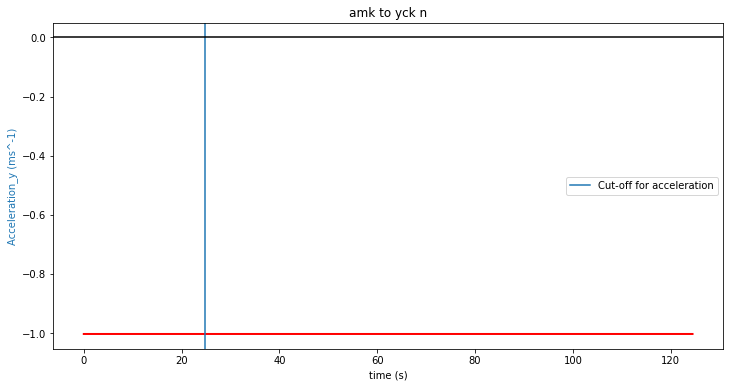

In [13]:
all_data = {'title': ['Station_start', 'Station_end', 'Total Distance', 'Total Time Taken (s)', 'Total Time w Offset (s)', 'Max Velocity (ms^-1)', 'Mean Acceleration', 'Cut-off t (s)', 'Method Used']}
for i, title in enumerate(acceleration_data):
    all_data[i] = plot_graph(acceleration_data[title], title)

In [ ]:
file_type = input("Would you like to output to a .csv or .txt file? Type 'csv' or 'txt': ").lower()

# Ensure input is either 'csv' or 'txt'
while True:
#     If file_type is neither 'csv' nor 'txt' > Ask for input again
    if file_type != 'csv' and file_type != 'txt':
        print(file_type.lower())
        file_type = input("Invalid input. Please input 'csv' or 'txt' to output data to a .csv or .txt file respectively: ")
    else:
        break
        
        
file_name = input("Please input the name of your file: ")


if file_type == 'csv':
    f = file_name + '.' + file_type
    
    with open(f, 'w', newline='') as file:
        for i in all_data:
            file.write(', '.join(str(el) for el in all_data[i]))
            file.write('\n')
else:
    f = file_name + '.' + file_type
    with open(f, 'w', newline='') as file:
        for i in all_data:
            file.write(', '.join(str(el) for el in all_data[i]))
            file.write('\n')

print(f'''
File completed! :)
Total Time Taken: {(time.time() - start_time):.1f}s''')